In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeB_for_modeling.csv")
df.head(n=3)


,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,school_name,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,ALL_RATE_,area_name,rural_urban_continuum_code,urban_influence_code,metro_or_not,civilian_labor_force,unemployment_rate
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,BETHEL REGIONAL HIGH SCHOOL,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,52.0,"Bethel Census Area, AK",7.0,11.0,0.0,7193.0,15.6
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,BETHEL ALTERNATIVE BOARDING SCHOOL,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,10.0,"Bethel Census Area, AK",7.0,11.0,0.0,7193.0,15.6
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,MT. EDGECUMBE HIGH SCHOOL,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,97.5,"Sitka Borough/city, AK",7.0,11.0,0.0,4627.0,5.7


# New Feature Creation

In [4]:
# Create features for common words found in school names
# E.g. name_mission is a binary column with a 1 in it if that particular school has the word 'mission' in its name.

import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

list_of_words_in_name = df.SCHNAM.str.lower().str.split().to_list()
flat_list = [item for sublist in list_of_words_in_name for item in sublist]

list(map(len, [list_of_words_in_name, flat_list]))

# Do not want a bunch of location identifiers. Remove state names and require word to appear in at least 100 schools
# to remove the vast majority of county names. Highly unlikely to have more than 100 schools in a county.

from collections import Counter

sorted__by_freq = dict(
    sorted(Counter(flat_list).items(), key=lambda item: item[1], reverse=True)
)
chopped_freq_ends = []
for k, v in sorted__by_freq.items():
    if v < 3000 and v > 100:
        chopped_freq_ends += [k]

no_stops = set(chopped_freq_ends) - set(stopwords.words("english"))
no_stops_no_states = (
    no_stops - set(df.STNAM.str.lower().unique()) - set(["bronx", "brooklyn", "sch"])
)
no_stops_no_states = list(no_stops_no_states)[7:]
no_stops_no_states = [word for word in no_stops_no_states if len(word) > 2]
no_stops_no_states

for word in no_stops_no_states:
    df["name_" + word] = np.int64(df.SCHNAM.str.lower().str.contains(word))

# Create features by dividing one column by another or subtracting one column from another.

df["teacher_ratio1"] = df.teachers_fte / df.enrollment
df["teacher_ratio2"] = df.teachers_fte / df.ALL_COHORT_
df["num_grades"] = df.highest_grade_offered - df.lowest_grade_offered

df.to_csv("../data/mergeB_for_modeling_features_engineered.csv", index=False)


[nltk_data] Downloading package stopwords to /home/bb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_188738/709615648.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["name_" + word] = np.int64(df.SCHNAM.str.lower().str.contains(word))
/tmp/ipykernel_188738/709615648.py:36: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["name_" + word] = np.int64(df.SCHNAM.str.lower().str.contains(word))
/tmp/ipykernel_188738/709615648.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["name_" + word] = np.int64(df.SCHNAM.str.lower().str.contains(wor

In [5]:
# Subset to features that we believe have unique information in them; e.g. removing ID columns, names as strings.
# Categoricals like FIPST, LEAID, zip_location, and county_code like have some useful information but may have too many categories (1000s)
# to dummy encode. Also we do not want to have our model score schools based on what code or state they are in.

X = df.copy()

X.drop(
    [
        "STNAM",
        "LEANM",
        "NCESSCH",
        "SCHNAM",
        "school_name",
        "zip_mailing",
        "LEAID",
        "zip_location",
        "county_code",
        "FIPST",
        "area_name",
        "Year",
    ],
    inplace=True,
    axis=1,
)


y = X.pop("ALL_RATE_")

# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = [
    "Rla_Pct_Part",
    "Math_Pct_Part",
    "enrollment",
    "free_lunch",
    "reduced_price_lunch",
    "free_or_reduced_price_lunch",
    "teachers_fte",
    "lowest_grade_offered",
    "highest_grade_offered",
    "latitude",
    "ALL_COHORT_",
    "civilian_labor_force",
    "unemployment_rate",
    "teacher_ratio1",
    "teacher_ratio2",
    "num_grades",
]

for col in numeric_cols:
    assert col in X.columns
categoricals = list(set(X.columns.tolist()) - set(numeric_cols))

# Convert categoricals to the pandas type 'category'
for col in categoricals:
    X[col] = X[col].astype("category")

pd.set_option("display.max_rows", 999)
X.dtypes


ALL_COHORT_                       int64
latitude                        float64
urban_centric_locale           category
school_level                   category
school_type                    category
lowest_grade_offered            float64
highest_grade_offered           float64
title_i_status                 category
title_i_eligible               category
charter                        category
magnet                         category
virtual                        category
teachers_fte                    float64
free_lunch                      float64
reduced_price_lunch             float64
free_or_reduced_price_lunch     float64
enrollment                      float64
ungrade_cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
rural_urban_continuum_code     category
urban_influence_code           category
metro_or_not                   category
civilian_labor_force            float64
unemployment_rate               float64


In [6]:
# Create train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)


In [7]:
Xtrain.head(n=2)


,ALL_COHORT_,latitude,urban_centric_locale,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,rural_urban_continuum_code,urban_influence_code,metro_or_not,civilian_labor_force,unemployment_rate,name_charter,name_john,name_columbia,name_technical,name_connections,name_leadership,name_franklin,name_public,name_valley,name_sciences,name_mount,name_design,name_jefferson,name_king,name_western,name_county,name_rock,name_river,name_kennedy,name_wilson,name_park,name_bay,name_education,name_learning,...,name_southern,name_harbor,name_pleasant,name_angeles,name_oak,name_houston,name_preparatory,name_comm,name_northwest,name_st.,name_robert,name_falls,name_studies,name_beach,name_science,name_lakes,name_engineering,name_port,name_alliance,name_collegiate,name_lincoln,name_prep,name_day,name_pine,name_sr.,name_point,name_secondary,name_green,name_sierra,name_madison,name_(alternative),name_big,name_red,name_southwest,name_health,name_online,name_tech,name_co.,name_del,name_urban,name_middle,name_spring,name_special,name_white,name_heights,name_summit,teacher_ratio1,teacher_ratio2,num_grades
28263,18,39.80761,43.0,3.0,1.0,7.0,12.0,1.0,1.0,0.0,0.0,0.0,18.000000,58.0,21.0,79.0,146.0,0.0,90.0,90.0,9.0,12.0,0.0,1518.0,2.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.123288,1.00000,5.0
12172,40,35.35770,42.0,3.0,1.0,7.0,12.0,5.0,1.0,0.0,0.0,0.0,32.709999,130.0,49.0,179.0,277.0,0.0,97.5,95.0,4.0,5.0,0.0,35304.0,7.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.118087,0.81775,5.0


In [8]:
ytrain.head(n=2)


28263    90.0
12172    95.0
Name: ALL_RATE_, dtype: float64

In [9]:
# Show our stratification on y. They have very similar distributions
ytrain.describe() - ytest.describe()


count    33462.000000
mean        -0.005485
std          0.007674
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: ALL_RATE_, dtype: float64

# RandomForest Regression

In [9]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV

clf = {}


In [10]:
import warnings
import joblib
import os

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
param_grid = {
    "rf__n_estimators": [500,600],
    "rf__max_features": [55,60,65],
    "rf__max_depth": [80, 100],
    "rf__ccp_alpha": [0.0],
    "rf__random_state": [42],
}
pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
        ("rf", RandomForestRegressor()),
    ]
)

# Load model from disk instead of running again.
clf = {}
local_model_path = (
    "../../student_outcome_saved_models/model_datasetB_random_forest_gridsearch1.pkl"
)
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe,
        param_grid,
        n_jobs=4,
        verbose=3,
        cv=4,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)


* Tune parameters
* Run model on train and test and sets
*  Visualize
*  Feature Importance

In [11]:
# Print out best parameters
print(clf.best_params_)
clf.cv_results_

# Best param first round
# {'rf__ccp_alpha': 0.0, 'rf__max_depth': 100, 'rf__max_features': 60, 'rf__n_estimators': 500, 'rf__random_state': 42}


{'rf__ccp_alpha': 0.0, 'rf__max_depth': 100, 'rf__max_features': 60, 'rf__n_estimators': 500, 'rf__random_state': 42}


{'mean_fit_time': array([ 54.18982309,  90.64032668,  12.55172741,  86.72640973,
        148.25959682,  19.16694695, 115.17741251, 174.3054778 ,
         22.04770017, 171.9037801 , 265.07112718,  32.45539904,
         50.84316522,  79.81729716,  10.17726791,  77.02038527,
        135.70373583,  16.12446141, 104.6795283 , 177.47726566,
         21.12546962, 155.01002103, 266.43063921,  33.28486782,
         48.72678286,  78.88445586,   9.74005961,  78.86453712,
        128.27337193,  15.86270565, 105.16951108, 175.48928326,
         21.43572915, 161.90638536, 264.05397213,  31.92829758,
        499.08130562, 844.68208987,  98.671655  , 483.10240269,
        788.64203238,  95.81822491, 479.89248502, 814.96628058,
         96.28560847, 494.7284897 , 873.27498043, 106.93486351,
        517.52561605, 874.39375591, 103.94692159, 499.04729718,
        796.46453941,  95.71509629, 481.55392998, 820.47553188,
         99.83687794, 542.42600054, 912.86084819, 112.89269674,
        541.83333552, 8

In [12]:
categoricals

['name_city',
 'name_special',
 'name_learning',
 'name_technology',
 'name_robert',
 'name_del',
 'name_(the)',
 'name_central',
 'name_public',
 'name_comm',
 'name_angeles',
 'name_middle',
 'name_san',
 'name_harbor',
 'name_mount',
 'name_technical',
 'name_liberty',
 'name_international',
 'urban_centric_locale',
 'name_new',
 'magnet',
 'name_columbia',
 'name_santa',
 'name_jr/sr',
 'name_miami',
 'name_green',
 'name_canyon',
 'name_wilson',
 'name_lake',
 'name_henry',
 'name_roosevelt',
 'name_charles',
 'name_hall',
 'name_marshall',
 'rural_urban_continuum_code',
 'name_secondary',
 'name_preparatory',
 'name_independence',
 'name_houston',
 'name_gateway',
 'name_engineering',
 'name_rapids',
 'name_grand',
 'name_grove',
 'name_institute',
 'name_spring',
 'urban_influence_code',
 'name_schools',
 'name_thomas',
 'name_southwest',
 'name_st.',
 'name_oak',
 'name_sr.',
 'name_charter',
 'name_attendance',
 'name_alliance',
 'name_mt.',
 'name_prep',
 'name_jshs',
 'name_

# Check best parameters on the test set

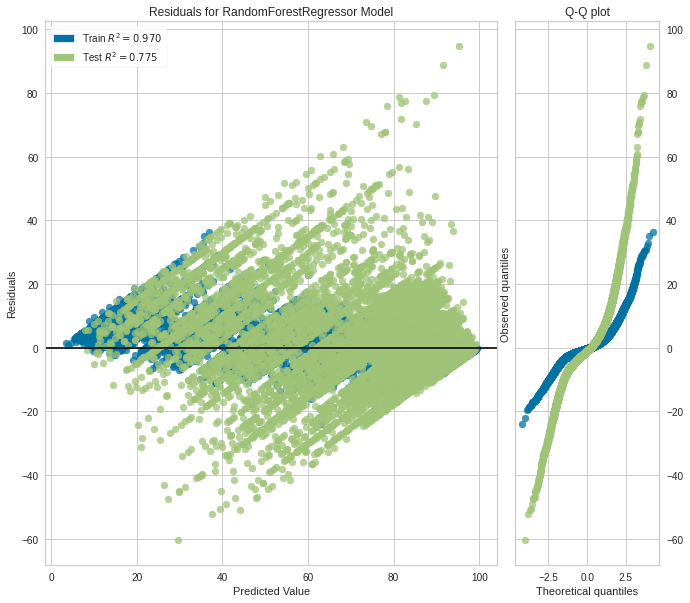

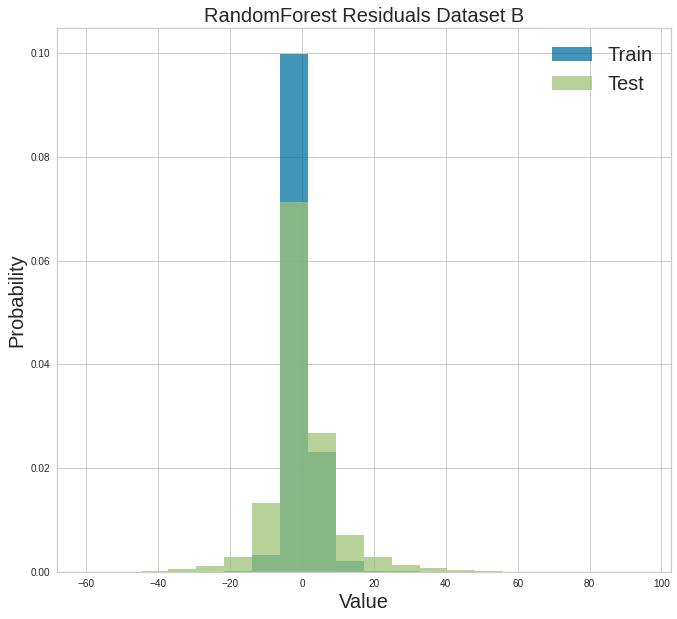

train rmsd =  3.3698218145182817
train r2 =  0.9699778362302701
test rmsd =  9.23010477337957
test r2 =  0.7745752023306953


In [17]:
# Validate the best model on the train and test sets

# The fact that our residuals are far from normal suggests that we could improve our model.

from sklearn.metrics import r2_score

scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=categoricals+numeric_cols)

pipe2 = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=False, variables=categoricals)), 
        (
            "rf",
            RandomForestRegressor(
                n_jobs=4,
                max_features=50,
                n_estimators=500,
                max_depth=100,
                random_state=42,
            ),
        ),
    ]
)
pipe2.fit(Xtrain, ytrain)
plt.rcParams["figure.figsize"] = (11, 10)
residuals_plot(pipe2, Xtrain, ytrain, Xtest, ytest, hist=False, qqplot=True)
plt.show()

train_residuals = pipe2.predict(Xtrain) - ytrain
test_residuals = pipe2.predict(Xtest) - ytest

bins = np.histogram(np.hstack([train_residuals, test_residuals]), bins=20)[1]
plt.hist(train_residuals, density=True, alpha=0.75, bins=bins, label="Train")
plt.hist(test_residuals, density=True, alpha=0.75, bins=bins, label="Test")
plt.xlabel("Value", fontsize=20)
plt.ylabel("Probability", fontsize=20)
plt.title("RandomForest Residuals Dataset B", fontsize=20)
plt.legend(fontsize=20)
plt.show()
print("train rmsd = ", train_residuals.describe()[2])
print("train r2 = ", r2_score(ytrain, pipe2.predict(Xtrain)))
print("test rmsd = ", test_residuals.describe()[2])
print("test r2 = ", r2_score(ytest, pipe2.predict(Xtest)))


# Feature Importance from Random Forest


<BarContainer object of 200 artists>

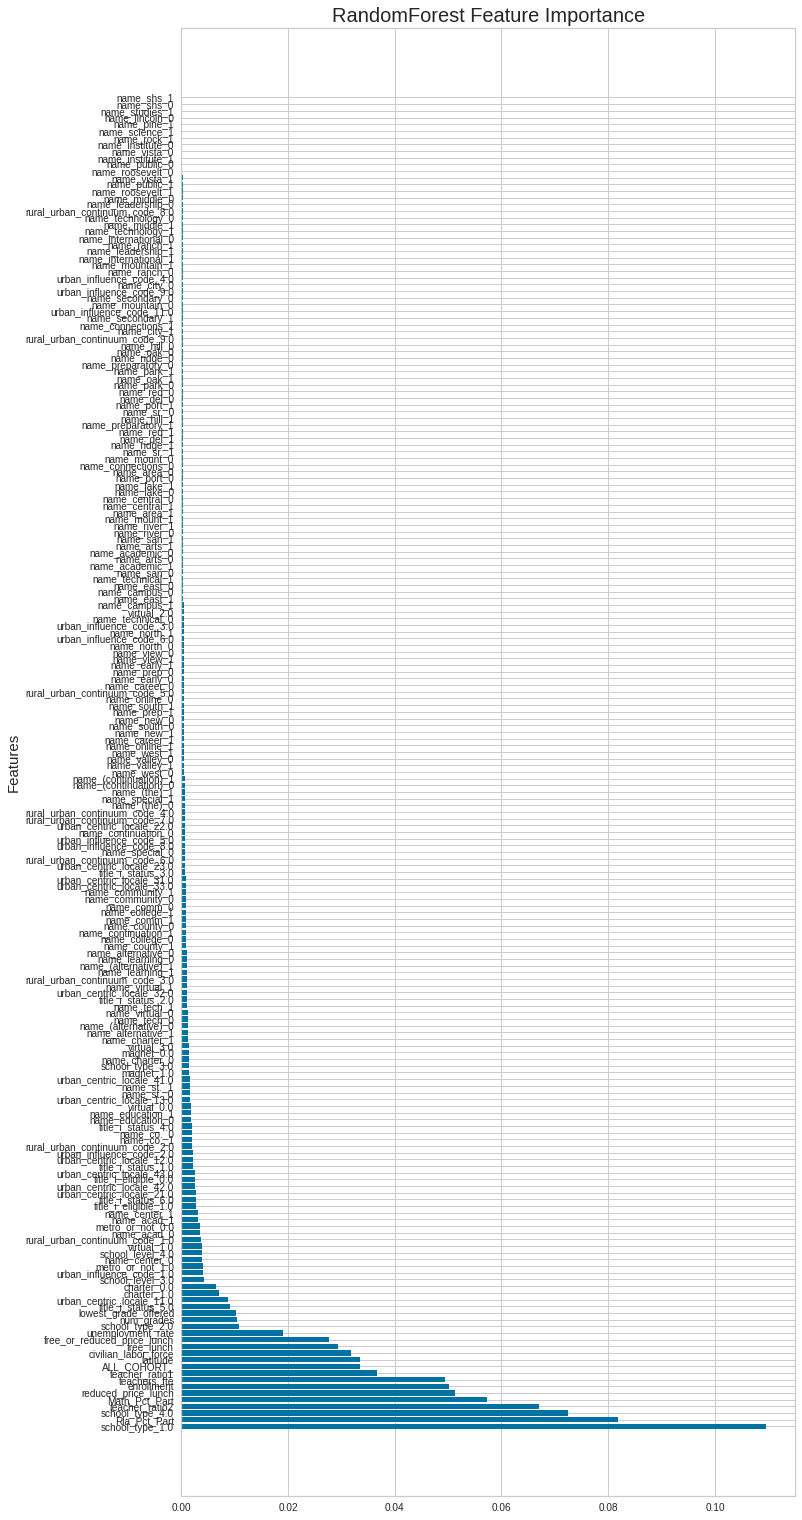

In [19]:
assert len(pipe2._final_estimator.feature_names_in_) == len(
    pipe2._final_estimator.feature_importances_
)
feature_importances = list(
    zip(
        pipe2._final_estimator.feature_names_in_,
        pipe2._final_estimator.feature_importances_,
    )
)
sorted_features = sorted(feature_importances, key=lambda x: x[1], reverse=True)
names = [i[0] for i in sorted_features[:200]]
values = [i[1] for i in sorted_features[:200]]
plt.title("RandomForest Feature Importance", fontsize=20)
plt.ylabel(ylabel="Features", fontsize=15)
plt.rcParams["figure.figsize"] = (11, 27)
plt.barh(names, values)

/tmp/ipykernel_188738/3212157310.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df2.poly = polynomial.fit_transform(df2)
/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/feature_engine/encoding/one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{feature}_{category}"] = np.where(X[feature] == category, 1, 0)
/home/bb/miniconda3/envs/my-env/lib/python3.10/site-packages/feature_engine/encoding/one_hot.py:252: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

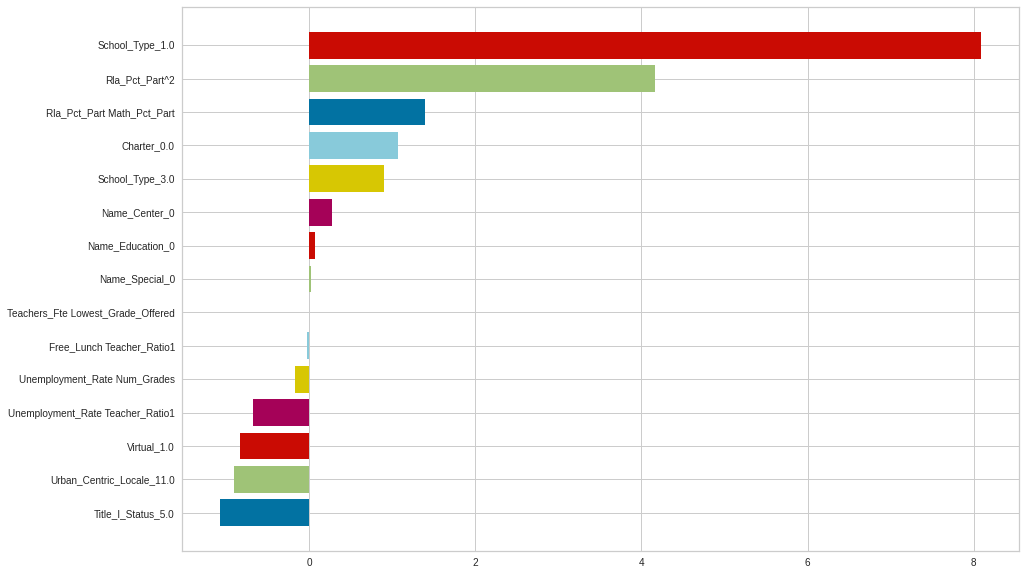

In [13]:
# First, reduce number of features
# OneHot, Polynomial the numeric features, scale numeric features.
# Lasso to reduce features 
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from yellowbrick.datasets import load_concrete
from yellowbrick.model_selection import FeatureImportances

df2 = pd.read_csv("../data/mergeB_for_modeling_features_engineered.csv") 

df2.drop(
    [
        "STNAM",
        "LEANM",
        "NCESSCH",
        "SCHNAM",
        "school_name",
        "zip_mailing",
        "LEAID",
        "zip_location",
        "county_code",
        "FIPST",
        "area_name",
        "Year",
    ],
    inplace=True,
    axis=1,
)
y = df2.pop('ALL_RATE_')

# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = [
    "Rla_Pct_Part",
    "Math_Pct_Part",
    "enrollment",
    "free_lunch",
    "reduced_price_lunch",
    "free_or_reduced_price_lunch",
    "teachers_fte",
    "lowest_grade_offered",
    "highest_grade_offered",
    "latitude",
    "ALL_COHORT_",
    "civilian_labor_force",
    "unemployment_rate",
    "teacher_ratio1",
    "teacher_ratio2",
    "num_grades",
]

for col in numeric_cols:
    assert col in df2.columns
categoricals = list(set(df2.columns.tolist()) - set(numeric_cols))

# Convert categoricals to the pandas type 'category'
for col in categoricals:
    df2[col] = df2[col].astype("category")

polynomial = SklearnTransformerWrapper(transformer=PolynomialFeatures(degree=2), variables=numeric_cols)
onehotter = OneHotEncoder(drop_last=True, variables=categoricals)

df2.poly = polynomial.fit_transform(df2)
df2.onehot = onehotter.fit_transform(df2.poly)
scaler = SklearnTransformerWrapper(transformer=StandardScaler(), variables=df2.onehot.select_dtypes(include=np.number).columns.tolist())
df2.scaled = scaler.fit_transform(df2.onehot)


# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), df2.scaled.columns.tolist()))
viz = FeatureImportances(Lasso(), labels=labels, relative=False,size=(1080,720),topn=15)
# Fit and show the feature importances
viz.fit(df2.scaled, y)
viz.fig.savefig("Lasso_Feature_Importances_DatasetB.png")